In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time

spectra_path        =   '../BRILLOUIN/Claudia/DaticellBoniPuntiDoppi/'
spectra_filename    =   '20191218_K27M'

VIPA_path           =   '../BRILLOUIN/Claudia/DaticellBoniPuntiDoppi/picchi_elastici_con_filtro_100msexp/Pos0/'
VIPA_filename       =   'img_000000000_Default_000.tif'


syg_kwargs          =   {'height': 20, 'distance': 20, 'width': 5.}
syg_kwargs_brill    =   {'height': 20, 'distance': 20, 'width': 5.}

cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

g:\Il mio Drive\RUOCCO\Python_Libraries\lib_Experimentum.py:70: RuntimeWarning: invalid value encountered in sqrt
  self.y_err      =   np.sqrt(self.y)
ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat
Lo spettro è bono


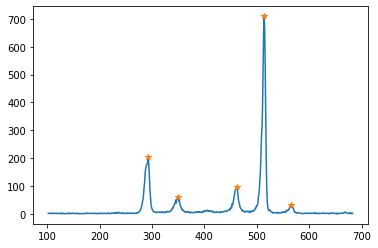

In [2]:
#0) importo dati e inizializzo oggetti
i   =   0
j   =   0

y    =   Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = True, cut_range = (100, 680))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, VIPA_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks[0]], Data.y[Data.peaks[0]], '*')


check = Data.Check_Spectrum(saturation_width = 13.5)

if      check == 1  : nature    = 'saturo'
elif    check == 2  : nature    = 'brillouin_higher'
elif    check == 3  : nature    = 'invisible'
else:                 nature    = 'bono'
print('Lo spettro è '+nature)

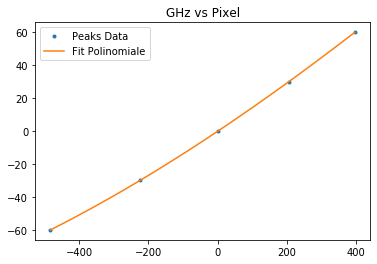

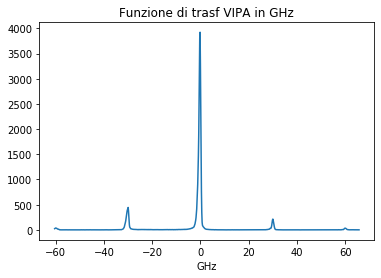



Ho stimato 12 parametri iniziali per il fit che andrai a fare

Co  = 1.000 

Omega  = 7.533 

Gamma  = 1.013 

Delta  = 1.013 

tau  = 100.000 

delta_width  = 0.500 

delta_amplitude  = 1.000 

A  =  nan 

mu  =  nan 

sigma  =  nan 

shift  = 0.000 

offset  = 14.578 

Ho stimato i parametri della gaussiana come A = 3965.50	mu  = -2.09	sigma = -13.30
E li ho aggiunti ai parametri iniziali per il fit. Ora conosco 12 parametri su 12 



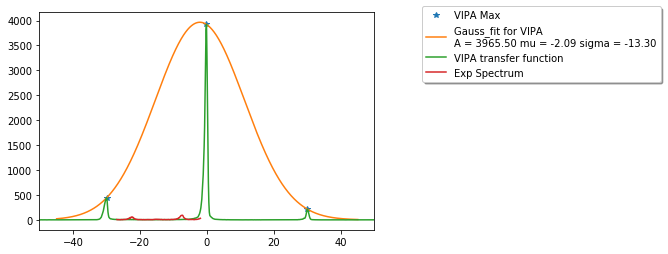

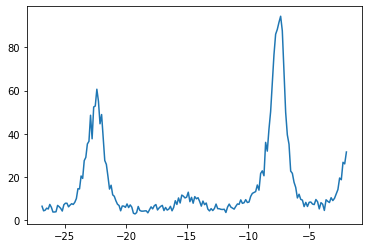

In [3]:
#1) Operazioni di modifica Spettro

Data.How_Many_Peaks_To_VIPA(treshold = 30)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)
Data.Spectrum_Pix2GHz()

if nature == 'brillouin_higher':  

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    Data.Get_Spectrum_4_Peaks_by_Order()

else:           

    Data.Get_Spectrum_4_Peaks_by_Height()

Data.Cut_n_Estimate_Spectrum(estimate = True, verbose = True, distanza = 0.25)
Data.Fit_VIPA_Gaussian(verbose = True, fig = True)
plt.figure()
plt.plot(Data.x_freq, Data.y)

costo = 133497.850924247
s impiegati a fare il fit  19.25 

costo dopo fit = 46.09544876356368
Valore stimato della cost function prima del fit:
315.2737438339487


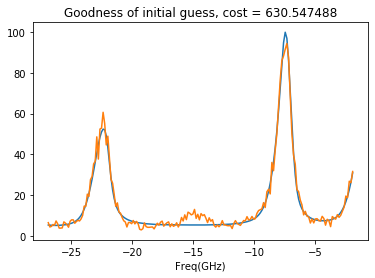

630.5474876678974

In [4]:
#3) fit markoviano

Data.Estimate_Initial_Parameters(p0 = Data.p0.values[0], treshold = 1000, columns = cols_mark)

Data.Take_A_Look_Before_Fitting()

Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6095e+01                                    5.43e-01    
       1              2         4.6095e+01      8.41e-05       1.00e+02       2.83e-01    
       2              3         4.6095e+01      5.29e-06       1.00e+02       2.11e-01    
       3              4         4.6095e+01      2.08e-05       2.51e+01       3.03e-02    
       4              5         4.6095e+01      1.12e-05       2.51e+01       9.88e-02    
       5              6         4.6095e+01      2.19e-05       5.02e+01       2.17e+00    
       6              9         4.6090e+01      5.18e-03       9.34e+00       4.82e-01    
       7             10         4.6090e+01      4.63e-04       9.95e+00       2.78e-01    
       8             11         4.6089e+01      7.22e-04       2.49e+00       1.61e-02    
       9             12         4.6089e+01      2.83e-05       1.03e+00       2.54e-02    
  

1

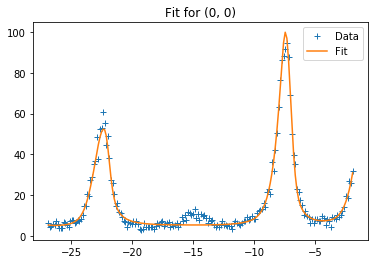

In [5]:
#4) fit totale
percents                    =   (0.2, 0.1, 0.15, 'positive', 'positive', 0.15, 0.15, np.inf, np.inf)
Data.Get_Fit_Bounds(percents, columns = cols_real)
p_gauss = Data.p0[list(cols_gauss)].values[0]
p0      = Data.p0[list(cols_real)].values[0]
Data.Non_Linear_Least_Squares(p0, p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 200)


In [6]:
Data.Fit_Params

,Co,Omega,Gamma,Delta,tau,delta_width,delta_amplitude,shift,offset
Values,0.080938,7.428153,0.109056,43.681363,161.368381,0.988463,0.027947,0.239492,3.804689
StdErrs,0.031685,2.965938,0.042664,11394.291906,43423.642061,0.213788,0.027063,0.021925,0.428953
Initials,0.080158,7.500754,0.107991,0.107991,100.000000,0.988498,0.027970,0.239490,3.809585
